---
title: "Calc 1: Newton's Method From The Ground Up"
date: 2023-11-03
draft: false
categories: ['Math']
tags: ['Python', 'Math']
math: true
---

In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import sympy
import imageio
from typing import Callable
import seaborn as sns


## Newton's Method for Finding Roots: What, How, and Why

In the context of a Differential Calculus course, [Newton's Method](https://en.wikipedia.org/wiki/Newton%27s_method#Applications), also referred to as The Newton-Raphson Method, seems to typically come up near the end of the semester, offering students a brief look into the world of "numerical methods" and how we might solve complex problems in the real world. I think that it's such a cool topic and first step from math into applied fields like statistics and optimization, that I wanted to write an extended blog post about it. The main purpose of this is to ensure that I always have personal reference materials for Newton's Method, but perhaps it can be helpful to other readers.

I draw on two key sources for thinking about Newton's Method:
1. [“Newton’s Method.”](https://en.wikipedia.org/w/index.php?title=Newton%27s_method&oldid=1177135929.) 2023. In Wikipedia
2. Strang, Gilbert, and Edwin Herman. 2016. [Calculus Volume 1](https://openstax.org/books/calculus-volume-1/pages/4-9-newtons-method). OpenStax College.

### What is it

>In many areas of pure and applied mathematics, we are interested in finding solutions to an equation of the form  $f(x)=0$  

(Strang 2016)  

Newton's Method is a numerical method that helps us solve $f(x)=0$.  

There are many cases where we need to solve equations like that, but the application area I work in is statistics, so I jump to the case where we want to "fit" a line as close as possible to some set of data points, thus creating a model of a data-generating-process. The fitting process rests on getting the line as close to the data points as possible, thus minimizing error. If we can formulate error as a function, then we can minimize it -- we differentiate it and set the derivative to 0, and solve $f'(x)=0$. Therein lies the opportunity to apply Newton's Method to a real problem.

However, we'll take a step back from statistics and return to the domain of an introductory calculus course. Newton's Method is useful for finding the root -- the x-intercept -- of a function. We'll explore the method by walking through an example

### Using Newton's Method to Solve a Simple Problem

Say we are given the function $4\sin(x)$ and we want to find the x-intercept of the function with the domain $-5\leq x \leq -1$.  

We'll first set this function up in `sympy`, a python library for symbolic computation.

In [30]:
x, y = sympy.symbols('x y')
y = 4*sympy.sin(x)
y


4*sin(x)


This is a problem with a known answer (you can google x-intercepts of $\sin(x)$ for a table), so it's not particularly useful to use Newton's Method here, but for our purposes it will be helpful that we can check our answer with the "right" one.
\begin{align*}
4 \sin(x) &= 0 \quad \text{where} \quad -5\leq x \leq -1\\\
\sin(x) &= 0 \\\
x &= \sin^{-1}(0) \\\
x &= -\pi
\end{align*}

{{< details "Utility functions" >}}

In [31]:
def plot_f(
        f: Callable[[float], float],
        x_low: int,
        x_high: int,
        ax: matplotlib.axes.Axes) -> None:
    """
    Plots a given function f within a specified range on a provided axes.

    Parameters:
        f (Callable[[float], float]): The function to be plotted.
        x_low (int): The lower bound of the x-axis.
        x_high (int): The upper bound of the x-axis.
        ax (matplotlib.axes.Axes): The matplotlib axes object on which the function will be plotted.

    Returns:
        None
    """
    x_vec = np.linspace(x_low, x_high, 100)
    ax.plot(x_vec, f(x_vec))


def base_plot(
        y: sympy.core.mul.Mul,
        x: sympy.core.mul.Mul,
        x_low: int = -5,
        x_high: int = 5) -> None:
    """
    Creates a base plot for a mathematical expression and its graph.

    Parameters:
        y (sympy.core.mul.Mul): The mathematical expression to be plotted.
        x (sympy.core.mul.Mul): The symbol representing the independent variable in the expression.
        x_low (int): The lower bound of the x-axis (default is -5).
        x_high (int): The upper bound of the x-axis (default is 5).

    Returns:
        tuple: A tuple containing the matplotlib figure and axes used for plotting.

    Note:
        The mathematical expression is first converted to a Python function using sympy.lambdify.
    The function is then plotted on the specified axes along with gridlines and labels.
    """
    f = sympy.lambdify(x, y)
    fig, ax = plt.subplots()
    ax.grid(alpha=.5)
    ax.axhline(0, color="black", alpha=.5)
    plot_f(f, x_low, x_high, ax)
    ax.set(title=f"$f(x)={sympy.latex(y)}$", xlabel="$x$", ylabel="$f(x)$")
    return fig, ax


def plot_truth(ax: matplotlib.axes.Axes) -> None:
    """
    Plots the true root of a function as a marker on the graph.

    Parameters:
        ax (matplotlib.axes.Axes): The matplotlib axes on which the marker will be plotted.

    Returns:
        None
    """
    ax.plot(-np.pi,
            0,
            "*",
            markersize=15,
            color="darkblue",
            label="True root, $-\pi$")


def plot_guess(
        ax: matplotlib.axes.Axes,
        guess: int,
        label: str) -> None:
    """
    Plots a guess or estimate as a marker on the graph.

    Parameters:
        ax (matplotlib.axes.Axes): The matplotlib axes on which the marker will be plotted.
        guess (int): The estimated value to be marked on the graph.
        label (str): Label for the marker.

    Returns:
        None
    """
    ax.plot(guess,
            0,
            "o",
            label=label)


def plot_guess_coords(
        ax: matplotlib.axes.Axes,
        guess: int,
        label: str,
        y: sympy.core.mul.Mul = y,
        x: sympy.core.mul.Mul = x):
    """
    Plots a guess or estimate with specific coordinates as a marker on the graph.

    Parameters:
        ax (matplotlib.axes.Axes): The matplotlib axes on which the marker will be plotted.
        guess (int): The estimated x-coordinate where the marker will be placed.
        label (str): Label for the marker.
        y (sympy.core.mul.Mul): The mathematical expression corresponding to the y-coordinate.
        x (sympy.core.mul.Mul): The symbol representing the independent variable (x).

    Returns:
        None
    """
    ax.plot(guess,
            y.subs(x, guess).evalf(),
            "s",
            label=label, color="black")


def euclidean_dist_to_truth(x): return np.sqrt((-np.pi - float(x))**2)


{{< /details >}}

Now we'll begin the process of using Newton's Method to arrive at that same answer of $x=-\pi$.
#### Step 1: Make a first guess and evaluate its (x, y) coordinates
For a first guess, it's typical to start close to 0. In our case, we'll try -2.

In [32]:
x_0 = -2

Let's get a sense of how good of a guess this is by plotting it

$$
\begin{align*}
f(x) &= 4 \sin \left( x \right) \\\
f(x_0) &= 4 \sin \left( -2 \right) \\\
f(x_0) &\approx −3.6371897 \\\
(x_0, y_0) &= (x_0, f(x_0)) \approx (-2, −3.6371897) 
\end{align*}
$$

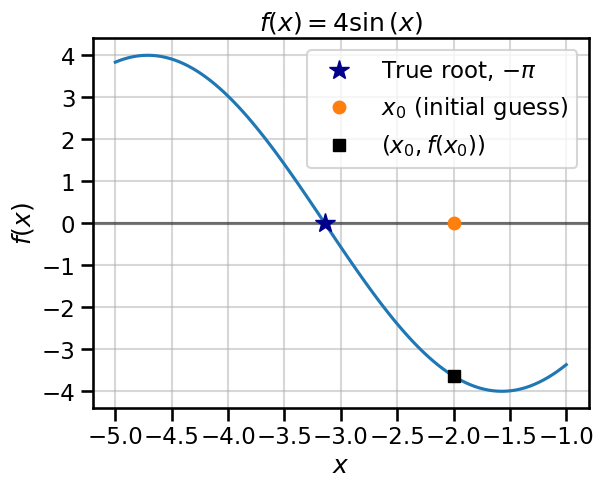

In [33]:
fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)
plot_guess(ax, x_0, "$x_0$ (initial guess)")
plot_guess_coords(ax, x_0, "$(x_0, f(x_0))$")
ax.legend();


We can assess the quality of that guess by calculating the distance from the guess to the right answer ($-\pi$):

In [34]:
print(f"error for guess x_0:", euclidean_dist_to_truth(x_0))


error for guess x_0: 1.1415926535897931


#### Step 2: Find the equation of the tangent line at those coordinates
We will proceed to improve upon that initial guess by computing the linear approximation of the function at that point, then retrieve its root to make a next-guess. Our first guess wasn't based on any relevant information other than the domain of our search (between -5 and 0). Our next guess is going to be better-informed, as it is an estimate based on an approximation of the function.  

(Note that the linear approximation at this point is typically referred to as a tangent line, and I'll use those two phrases interchangeably.)

We compute the tangent by first differentiating the function and plugging in our previous guess. This yields the slope of the tangent line:
$$
\begin{align*}
f(x) &= 4 \sin \left( x \right) \\\
f'(x) &= 4 \cos \left( x \right) \\\
f'(x_0) &= 4 \cos \left( -2 \right) \\\
f'(x_0) &\approx −1.6645873
\end{align*}
$$

I'll note that `sympy` is capable of doing all of these routine calculations as well:

In [35]:
print("   f(x) = ", y)
print("  f'(x) = ", y.diff())
print("f'(x_0) = ", y.diff().subs(x, -2))
print("[note: sympy converted x_0=-2 to x_0=2 because cos(-x)=cos(x)]")
print("f'(x_0) = ", y.diff().subs(x, x_0).evalf())


   f(x) =  4*sin(x)
  f'(x) =  4*cos(x)
f'(x_0) =  4*cos(2)
[note: sympy converted x_0=-2 to x_0=2 because cos(-x)=cos(x)]
f'(x_0) =  -1.66458734618857



Now, given each of these terms:  

|  Term (math)   | Value |
| -------- | ------- |
| $x_0$ (X, Last Guess)  | $= -2$   |
| $f(x_0)$ (Y at $x_0$) | $\approx −3.63719$     |
| $f'(x_0)$ (Slope of tangent at $x_0$)   | $\approx −1.66459$  |   

We can proceed to find the full equation of the tangent line by writing out the point-slope form of a linear equation with slope $m=f'(x_0)$.
$$
\begin{align*}
(y - y_0) &= m(x - x_0) \\\
(y - f(x_0)) &= f'(x_0)(x - x_0) \\\
y &= f'(x_0)(x - x_0) + f(x_0)
\end{align*}
$$
Plugging in our values, we get:

$$
\begin{align*}
y &\approx −1.66459x + (1.66459)(-2) - 3.63719 \\\
y &\approx −1.66459x - 6.966364 \\\
\end{align*}
$$  

We'll save that into a python function and plot it to make sure it does look like the tangent.



In [36]:
def f_1(x): return -1.6645873*x - 6.9663643


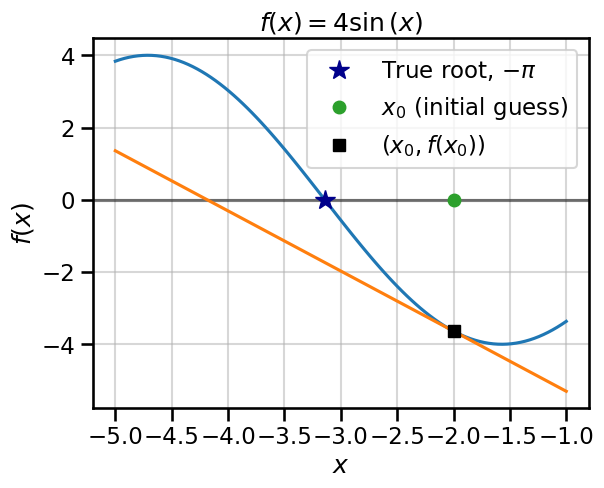

In [39]:
fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)

plot_f(f_1, x_low=-5, x_high=-1, ax=ax)

plot_guess(ax, x_0, "$x_0$ (initial guess)")
plot_guess_coords(ax, x_0, "$(x_0, f(x_0))$")

ax.legend();


#### Step 3: Find the x-intercept of the tangent line
Given that the tangent line is the **best linear approximation** of the original function, we can use its x-intercept as an approximation of the x-intercept of the original function. Thus, the root of the tangent line is the new "best-guess" of the original function's root.

$$
\begin{align*}
0 &\approx −1.6645873x_1 - 6.9663643\\\
\frac{6.9663643}{−1.6645873} &\approx x_1\\\
x_1 &\approx -4.1850
\end{align*}
$$

In [10]:
x_1 = -4.1850


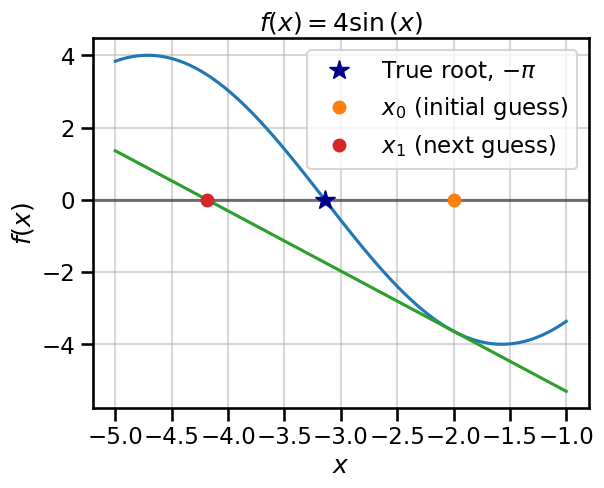

In [40]:
fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)
plot_guess(ax, x_0, "$x_0$ (initial guess)")
plot_f(f_1, x_low=-5, x_high=-1, ax=ax)
plot_guess(ax, x_1, "$x_1$ (next guess)")
ax.legend();


While this guess still isn't particularly great, we can see that we have actually reduced the "error" of our guess:

In [41]:
for i, x_n in enumerate([x_0, x_1]):
    print(f"error for guess x_{i}:", euclidean_dist_to_truth(x_n))


error for guess x_0: 1.1415926535897931
error for guess x_1: 1.0434073464102065


The big reveal of Newton-Raphson is that this error will continue to shrink as we repeat steps 1-3.

#### Step 4: Repeat
We will again find the tangent line at this new point, $(x_1, f(x_1))$. We could take the old tangent line equation, $y = f'(x_0)(x - x_0) + f(x_0)$ and simply update all of those $x_0$ to $x_1$, but at this point it will benefit us to move towards a more general equation: 
$$
y = f'(x_n)(x - x_n) + f(x_n)
$$
This allows us to generate the tangent line at any given guess, $x_n$. The following code leverages `sympy` to write that equation as a python function. 

In [42]:
def y_n(x_n): return (
    y.diff().subs(x, x_n) * (x - x_n) +  # f_1(x_1)(x-x_1) +
    y.subs(x, x_n)  # f(x_1)
)


In [43]:
y_n(x_1)


-2.01311525745113*x - 4.96839101072835

We'll also use `sympy` to easily solve for the new tangent line's x-intercept, $x_2$

In [44]:
x_2 = sympy.solve(y_n(x_1), x)[0]
x_2


-2.46801120419652

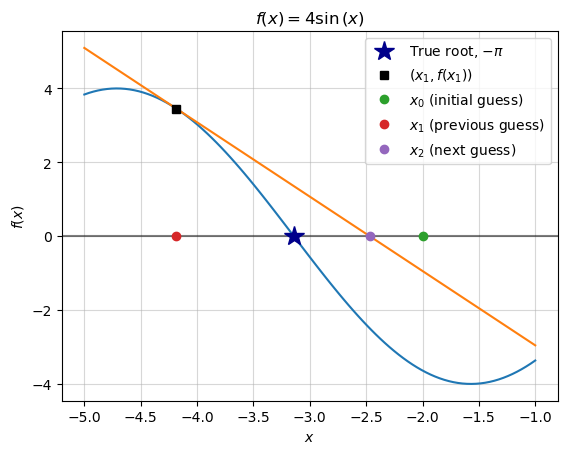

In [46]:
fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)
plot_f(sympy.lambdify(x, y_n(x_1)), x_low=-5, x_high=-1, ax=ax)

plot_guess_coords(ax, x_1, "$(x_1, f(x_1))$")

plot_guess(ax, x_0, "$x_0$ (initial guess)")
plot_guess(ax, x_1, "$x_1$ (previous guess)")
plot_guess(ax, x_2, "$x_2$ (next guess)")

ax.legend();


We can verify that this new guess again reduces our "error," which should encourage us to continue this process.


In [17]:
for i, x_n in enumerate([x_0, x_1, x_2]):
    print(f"error for guess x_{i}:", euclidean_dist_to_truth(x_n))


error for guess x_0: 1.1415926535897931
error for guess x_1: 1.0434073464102065
error for guess x_2: 0.6735814493932737


#### Step 5: Generalize the procedure

##### A.) Make the equation more direct
Thus far we have used the general equation $y = f'(x_n)(x - x_n) + f(x_n)$, where $x_n$ is our current guess, and we solve for $x$ to define our next guess. Given that we solve the equation for $x$, we can rewrite it as follows:  
$$
\begin{align*}
0 &= f'(x_n)(x - x_n) + f(x_n)\\\
0 &= f'(x_n)(x - x_n) + f(x_n) \\\
0 - f(x_n) &= f'(x_n)(x - x_n)\\\
-\frac{f(x_n)}{f'(x_n)} &= x - x_n\\\
x &= x_n -\frac{f(x_n)}{f'(x_n)}\\\
\end{align*}
$$
This expresses *one step* of Newton's Method -- solving for the x-intercept of the tangent line at the point $(x_n, f(x_n))$.  

##### B.) Move from equation to algorithm

We now build on this single step and express the general *process* of Newton's method. To start, it's more accurate to label the left hand side $x_{n+1}$ given that it represents the next guess:
$$
x_{n+1} = x_n -\frac{f(x_n)}{f'(x_n)}
$$  
Given this equation, we can think of Newton's Method as essentially searching for good guesses -- defining new $x_{n+1}$ -- until it's right. But how do we define "right"? Put in other words, **when do we stop?**  

In our case, we are working with a simple function and we know the correct answer -- we can just stop once we get close to $-\pi$ -- but in any real application that won't be the case. In those cases, it is common practice to define "right" as when the guesses stop changing much with each iteration. Stated semi-formally, we wait until $|x_{n+1} - x_{n}|$ gets small.  

For example: if the last guess was -3.14159 and the new guess is -3.141592, the guess only changed by .0000002, and we might conclude that we've gotten as close to the answer as is necessary. In this case, we set a stopping condition -- when the next guess is less than or equal to .0000002 away from the previous one, we stop. We can write out the stopping condition as follows:

$$
\begin{align*}
|x_{n+1} - x_{n}| &\leq 2\times 10^{-7} \\
|(x_n -\frac{f(x_n)}{f'(x_n)}) - x_{n}| &\leq 2\times 10^{-7} \\
|-\frac{f(x_n)}{f'(x_n)}| &\leq 2\times 10^{-7} \\
|\frac{f(x_n)}{f'(x_n)}| &\leq 2\times 10^{-7}
\end{align*}
$$  

We can try writing out the recursive algorithm as a piece-wise equation:  


$$
\begin{align*}
\text{Let } x_0 := \text{initial guess, } \\\
\text{For all natural numbers } n \ge 0, \\\
\text{Define }  x_{n+1} \text{ as:}
\end{align*}
$$

$$
x_{n+1} = \begin{cases}
        x_n & \text{if }\quad |\frac{f(x_n)}{f'(x_n)}| \leq 2\times 10^{-7} \\\
        x_n -\frac{f(x_n)}{f'(x_n)} & \text{Otherwise}
        \end{cases}
$$

However, now that we are moving into the realm of algorithms, I think it's clearer to write this as code:

In [18]:
x_n = -2

# We'll use this to count which guess we are on
counter = 1
while True:
    # Disregard the following utility code
    print(f"Guess {counter}:",
          str(round(float(x_n), 5)).ljust(8, '0'),
          " --- Error:",
          euclidean_dist_to_truth(x_n))
    ################################################
    # The following is the code for newton's method
    # 1.) Check for the stopping condition,
    # |f(x_n)/f'(x_n)| < 2 * 10^-7
    stop_condition = (
        np.abs(sympy.lambdify(x, y)(x_n) /
               sympy.lambdify(x, y.diff())(x_n))
        < 2e-7
    )
    if stop_condition:
        print(f"Converged in {counter} steps.")
        break
    # 2.) If stopping condition not met, make a new guess
    x_n = x_n - (
        # f(x_n) /
        sympy.lambdify(x, y)(x_n) /
        # f'(x_n)
        sympy.lambdify(x, y.diff())(x_n)
    )
    ################################################
    # Update the counter
    counter += 1


Guess 1: -2.00000  --- Error: 1.1415926535897931
Guess 2: -4.18504  --- Error: 1.0434472096717258
Guess 3: -2.46789  --- Error: 0.6736989790751275
Guess 4: -3.26619  --- Error: 0.1245936239793135
Guess 5: -3.14094  --- Error: 0.00064874127215786
Guess 6: -3.14159  --- Error: 9.101119857746198e-11
Converged in 6 steps.


We've converged at our best-guess after six steps, which we can see animated below.


{{< details "GIF Code" >}}

In [19]:
%%capture
x_n = -2
max_iter = 10
tolerance = 1e-6

fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)
ax.set_ylim(-4, 4)
ax.set_xlim(-4.5, -1.5)

images = []
breaking_condition = False
for j in range(max_iter):
    error = euclidean_dist_to_truth(x_n)
    if error < tolerance:
        breaking_condition = True

    ax.set_title(
        f"Iteration {j+1}\nGuess: {round(x_n, 6)}\n Error: {round(error, 8)}")

    # Plot the current guess
    plot_guess(ax, x_n, "$x_n$")
    filename = f'newton_iteration_{j}_0.png'
    fig.savefig(filename)
    images.append(imageio.imread(filename))

    if breaking_condition:
        ax.text(x_n, 2, s=f"CONVERGED IN {j} STEPS", size=15)
        filename = f'newton_iteration_{i}_3.png'
        fig.savefig(filename)
        images.append(imageio.imread(filename))
        ax.text(x_n, 2, s=f"CONVERGED IN {j} STEPS", size=15)
        filename = f'newton_iteration_{i}_4.png'
        fig.savefig(filename)
        images.append(imageio.imread(filename))
        break
    # Plot the coordinates of the current guess
    plot_guess_coords(ax, x_n, "$(x_n, f(x_n))$")
    filename = f'newton_iteration_{j}_1.png'
    fig.savefig(filename)
    images.append(imageio.imread(filename))
    # Plot the tangent line of that coordinate to inform next guess
    plot_f(sympy.lambdify(x, y_n(x_n)), x_low=-5, x_high=-1, ax=ax)
    filename = f'newton_iteration_{j}_2.png'
    fig.savefig(filename)
    images.append(imageio.imread(filename))

    # Reset plot
    ax.clear()
    fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
    plot_truth(ax)
    ax.set_ylim(-4, 4)
    ax.set_xlim(-4.5, -1.5)

    x_n -= (
        sympy.lambdify(x, y)(x_n) /
        sympy.lambdify(x, y.diff())(x_n)
    )
imageio.mimsave('newton_iterations.gif', images, duration=1)

# Clean out pngs
wd = os.getcwd()
files = os.listdir(wd)
for item in files:
    if item.endswith(".png"):
        os.remove(os.path.join(wd, item))


{{< /details >}}

![gif](newton_iterations.gif?8 "gif")

### Using Newton's Method to Solve a Real Problem
In the previous example, we dealt with a function, $f(x) = 4\sin(x)$ with a well known analytical solution for its x-intercept. Other simple functions can typically be solved with known formulas -- e.g. a second degree polynomial's roots can be found using the quadratic formula. In cases of known analytical solutions or readily available root-finding formulas, there is no reason to use Newton's Method beyond as a learning exercise.  

However, many functions do not have have readily available methods for finding the root. For example, if $f(x)$ is a polynomial of degree 5 or greater, it is known that no formula for finding its roots exist (Strang 2016). Consider the following polynomial of degree 5:
$$
f(x) =x^{5} + 8 x^{4} + 4 x^{3} - 2 x - 7
$$
What if we are asked to solve the following:
$$
f(x)=0 \quad \text{where} -5\leq x \leq 0\\\
$$
There is no formula that solves this. Even plugging the polynomial into `sympy` and running its solver, `sympy.solveset`, doesn't give a clear answer.

In [20]:
x, y = sympy.symbols('x y')
y = x**5 + 8*x**4 + 4*x**3 - 2*x-7
y


x**5 + 8*x**4 + 4*x**3 - 2*x - 7

In [21]:
print(sympy.solveset(y, x, sympy.Interval(-5, 0)))


{CRootOf(x**5 + 8*x**4 + 4*x**3 - 2*x - 7, 1)}


(where `CRootOf` is an indexed complex root of the polynomial -- not an analytical solution)

We might proceed to visually inspect the function on this domain -- but it's even pretty hard to visually spot a root here!

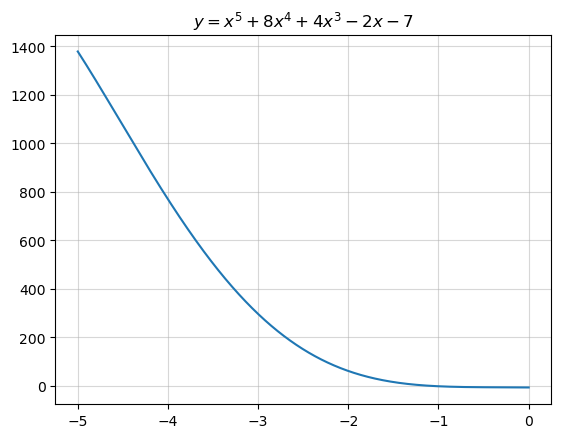

In [22]:
x_vec = np.linspace(-5, 0, 1000000)
fig, ax = plt.subplots()
ax.grid(alpha=.5)
ax.plot(x_vec, sympy.lambdify(x, y)(x_vec))
ax.set_title(f"$y={sympy.latex(y)}$");


Here's a good use-case for Newton's Method. I set up the algorithm with $x_0=0$ and a stopping condition that $|x_{n+1} - x_{n}| \leq 10^{-12}$.  
I quickly converge at an answer:

In [23]:
x_n = 0
tolerance = 1e-12
counter = 1

while True:
    # Disregard the following utility code
    print(f"Guess {counter}:",
          str(round(float(x_n), 5)).ljust(8, '0'),
          " --- Error:",
          euclidean_dist_to_truth(x_n))
    ################################################
    # The following is the code for newton's method
    # 1.) Check for the stopping condition,
    # |f(x_n)/f'(x_n)| < 2 * 10^-7
    stop_condition = (
        np.abs(sympy.lambdify(x, y)(x_n) /
               sympy.lambdify(x, y.diff())(x_n))
        < tolerance
    )
    if stop_condition:
        print(f"Converged in {counter} steps.")
        break
    # 2.) If stopping condition not met, make a new guess
    x_n = x_n - (
        # f(x_n) /
        sympy.lambdify(x, y)(x_n) /
        # f'(x_n)
        sympy.lambdify(x, y.diff())(x_n)
    )
    ################################################
    counter += 1


Guess 1: 0.000000  --- Error: 3.141592653589793
Guess 2: -3.50000  --- Error: 0.3584073464102069
Guess 3: -2.44316  --- Error: 0.6984302043961392
Guess 4: -1.81481  --- Error: 1.3267800055437047
Guess 5: -1.41471  --- Error: 1.726886024726261
Guess 6: -1.19062  --- Error: 1.9509769810235635
Guess 7: -1.11070  --- Error: 2.0308902060887837
Guess 8: -1.10108  --- Error: 2.0405099013561894
Guess 9: -1.10095  --- Error: 2.0406396683000647
Guess 10: -1.10095  --- Error: 2.040639691648806
Converged in 10 steps.


When we plot our best guess, $x_n$, we see that it is indeed the root of the function.

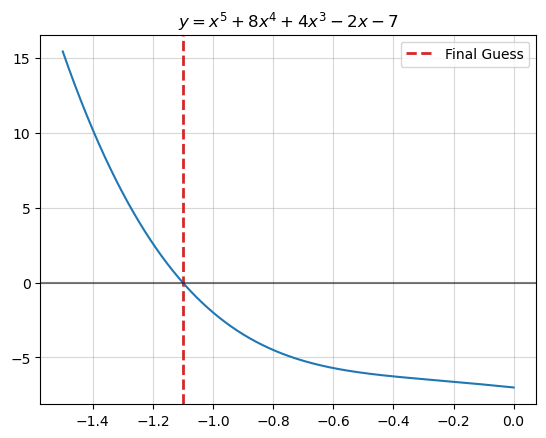

In [24]:
fig, ax = plt.subplots()

ax.axvline(x_n, linestyle="--", color="tab:red",
           linewidth=2, label="Final Guess")
ax.legend()

x_vec = np.linspace(-1.5, 0, 1000000)

ax.grid(alpha=.5)
ax.plot(x_vec, sympy.lambdify(x, y)(x_vec))
ax.set_title(f"$y={sympy.latex(y)}$")
ax.axhline(0, color="black", alpha=.5);


We can also compare our answer to what `sympy` gets from numerically solving for the function's root:

In [25]:
print("Newton's Method:", x_n)


Newton's Method: -1.1009529619409872


In [26]:
print("Sympy's answer:", sympy.solveset(y, x, sympy.Interval(-5, 0)).evalf())


Sympy's answer: {-1.10095296194099}


We see that we have basically the same answer as `sympy`.

## Newton's Method as Optimization
Recall that the derivative of a function is 0 at a critical point -- its maximum or minimum. We have been using Newton's Method to find the root of a function, but in the process **we've also implicitly been finding the critical point of the anti-derivative, or, integral of that function**.  

For visual intuition of this fact, consider the following plot, in which we visualize the integral of our function, $\int f(x) dx$, and plot the root of $f(x)$ that we just found using Newton's Method:

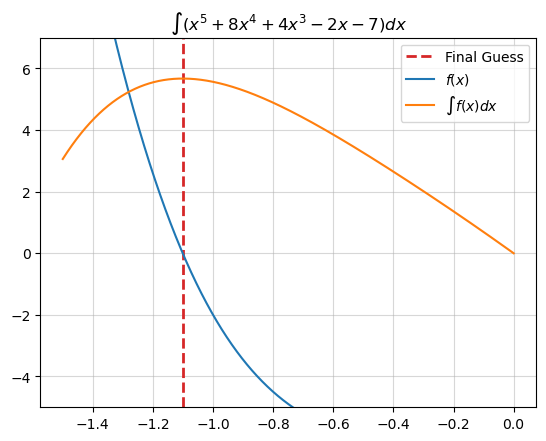

In [27]:
fig, ax = plt.subplots()

ax.axvline(x_n, linestyle="--", color="tab:red",
           linewidth=2, label="Final Guess")

ax.grid(alpha=.5)
ax.plot(x_vec, sympy.lambdify(x, y)(x_vec), label="$f(x)$")
ax.plot(x_vec, sympy.lambdify(x, y.integrate())(x_vec), label="$\int f(x) dx$")
ax.legend()
ax.set_ylim(-5, 7)
ax.set_title(f"$\int ({sympy.latex(y)})dx$");


The root of $f(x)$ seems to also be the maximum of $\int f(x) dx$.

**Why is this important?** Based on this idea, we can extend Newton's Method for general use in finding the critical value of a function, which means that we can use it for solving optimization problems. We can setup the optimization approach as follows:  
If the following equation will converge to the root of $f(x)$ and the critical point of $\int f(x) dx$: 
$$
\begin{align*}
x_{n+1} = x_n -\frac{f(x_n)}{f'(x_n)}
\end{align*}
$$
Then the following equation will converge to the root of $f'(x)$ and thus the critical point of $f(x)$ (equivalent to $\int f'(x)dx$):
$$
\begin{align*}
x_{n+1} = x_n -\frac{f'(x_n)}{f''(x_n)}
\end{align*}
$$